# Predicting Daily Asset Returns with Deep Learning

Author: Michael Honaker

## Configuration

---

**Data Loading**

`asset_type`: Asset type ('ETF' or 'Stock', case insensitive)

`asset_name`: Asset abbreviation (e.g. 'VOO', case insensitive)

`load_libraries`: Whether or not to reload Python libraries (True or False)

`load_data`: Whether or not to pull the data from Kaggle (True or False)

---

**Preprocessing**

`split`: Ratio split dictionary of available data for training, validation, and testing

`NUM_DAYS_INPUT`: Number of previous days to look at when making a prediction for tomorrow

`NUM_DAYS_STEP`: Number of days between the start of each training sample

---

**Modeling**

`UNITS`: Number of recurrent neurons in the LSTM layers

`DROPOUT_RATE`: Dropout rate between LSTM layers

`EPOCHS`: Number of training epochs

`BATCH_SIZE`: Number of input sequences for a single batch

---

**Simulation**

`INIT_CAPITAL`: Initial capital ($) for simulation

`K_FRAC`: Fraction of Kelly Criterion for signal multiplier

`SMOOTHING_FACTOR`: Split of the contribution of yesterday's signal multiplier and today's prediction to determine today's signal multiplier. (0: 0% yesterday, 100% today || 1: 100% yesterday, 0% today)

---

**Other**

`colors`: Color dictionary for different types of plots


In [1]:
# DATA LOADING
asset_type = 'ETF'
asset_name = 'VOO'
load_libraries = True
load_data = True

# PREPROCESSING
split = {
    'train': 0.8,
    'val': 0.1,
    'test': 0.1
}

NUM_DAYS_INPUT = 30
NUM_DAYS_STEP = 1

# MODELING
UNITS = 100
DROPOUT_RATE = 0.2
EPOCHS = 20
BATCH_SIZE = 32

# SIMULATION
INIT_CAPITAL = 100000
K_FRAC = 0.25
SMOOTHING_FACTOR = 0.0

# OTHER
colors = {
    'train': 'blue',
    'val': 'orange',
    'test': 'green',
    'pred': 'red'
}

## Load Python Libraries

In [2]:
if load_libraries:
  from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
  import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
  import scipy.stats as stats
  import matplotlib.dates as mdates

  from sklearn.preprocessing import MinMaxScaler, StandardScaler
  from sklearn.pipeline import Pipeline
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

  import tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds

  from google.colab import drive
  import zipfile
  from tqdm import tqdm

## Load Kaggle Data

---

**Source**

[Huge Stock Market Dataset - Boris Marjanovic](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)

---

**Description from Data Owner on the Data's Kaggle Page**

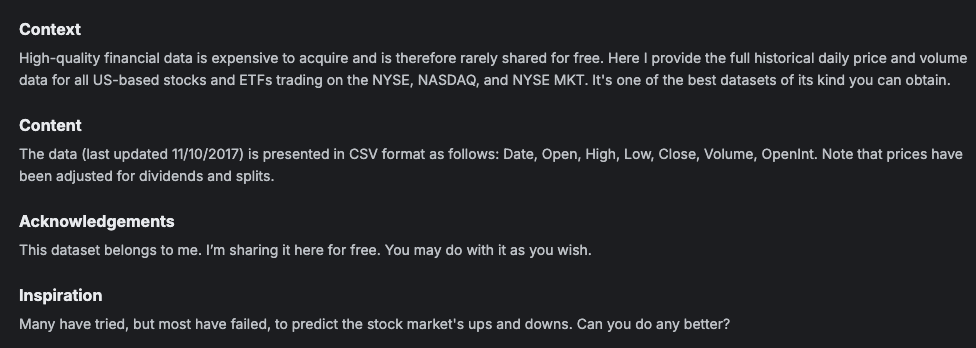

In [3]:
%%time

if load_data:
  drive.mount('/content/drive')

  !mkdir -p ~/.kaggle
  !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >>log
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs

  asset_name_dict = {}

  with zipfile.ZipFile('price-volume-data-for-all-us-stocks-etfs.zip', 'r') as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):

      if file.split('/')[0] != 'Data':
        continue

      zip_ref.extract(member=file, path='.')

      subfolder_load = file.split('/')[1]
      asset_name_load = file.split('/')[2].split('.')[0]

      if subfolder_load not in asset_name_dict:
        asset_name_dict[subfolder_load] = set()

      asset_name_dict[subfolder_load].add(asset_name_load)


  !rm price-volume-data-for-all-us-stocks-etfs.zip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
License(s): CC0-1.0
 94% 461M/492M [00:01<00:00, 380MB/s]
100% 492M/492M [00:01<00:00, 447MB/s]


100%|██████████| 17078/17078 [00:09<00:00, 1767.81it/s]


CPU times: user 7.94 s, sys: 1.79 s, total: 9.73 s
Wall time: 1min 6s


In [4]:

match asset_type.lower():
  case 'stock':
    subfolder = 'Stocks'
  case 'etf':
    subfolder = 'ETFs'
  case _:
    raise RuntimeError('Invalid asset type. Must be ETF or Stock. Stopping notebook.')

if asset_name.lower() not in asset_name_dict[subfolder]:
  raise RuntimeError(f'Invalid asset name. Stopping notebook.')

df = pd.read_csv(f'Data/{subfolder}/{asset_name.lower()}.us.txt')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.index = df['Date']
df = df.drop(columns=['Date', 'OpenInt'])

## Train/Validation/Test Split

In [5]:
train = df.iloc[:int(df.shape[0]*split['train'])]

val   = df.iloc[int(df.shape[0]*split['train']):int(df.shape[0]*(split['train'] + split['val']))]

test  = df.iloc[int(df.shape[0]*(split['train'] + split['val'])):]

## Exploratory Data Analysis (EDA)

In [6]:
def time_plot(train, val=None, test=None, label='', unit='', asset_type='', asset_name='', colors={'train': 'b'}):
  _ = plt.figure()
  _ = plt.title(f'{label} of {asset_type.upper()}: {asset_name.upper()} from {df.index.date[0]} to {df.index.date[-1]}')
  _ = plt.plot(train, linewidth=2, color=colors['train'])
  leg = ['train']
  if val is not None:
    _ = plt.plot(val, linewidth=2, color=colors['val'])
    leg.append('val')
  if test is not None:
    _ = plt.plot(test, linewidth=2, color=colors['test'])
    leg.append('test')
  _ = plt.legend(leg)
  _ = plt.gca().xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
  _ = plt.gcf().autofmt_xdate()
  _ = plt.xlabel('Year')
  _ = plt.ylabel(f'{label} [{unit}]')
  print()
  plt.show()

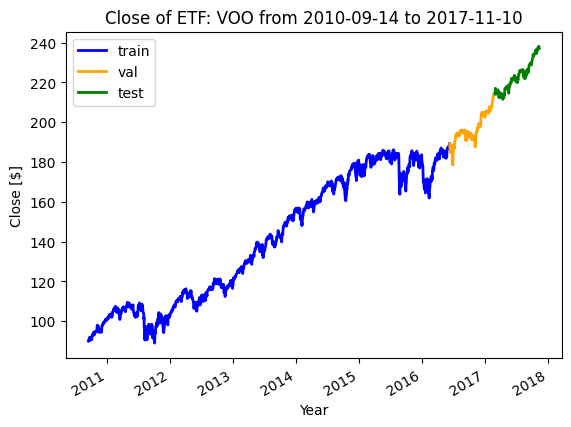

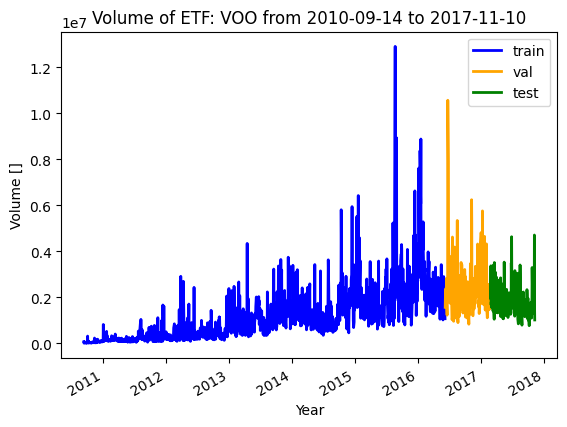

In [7]:
var_list = ['Close', 'Volume']
unit_list = ['$', '']
for var, unit in zip(var_list, unit_list):
  time_plot(train=train[var], val=val[var], test=test[var], label=var, unit=unit, asset_type=asset_type, asset_name=asset_name, colors=colors)

In [8]:
def RoR(x0, x1):
  return 100 * (x1 - x0) / x0

In [9]:
def logReturn(x0, x1):
  return np.log(x1 / x0)

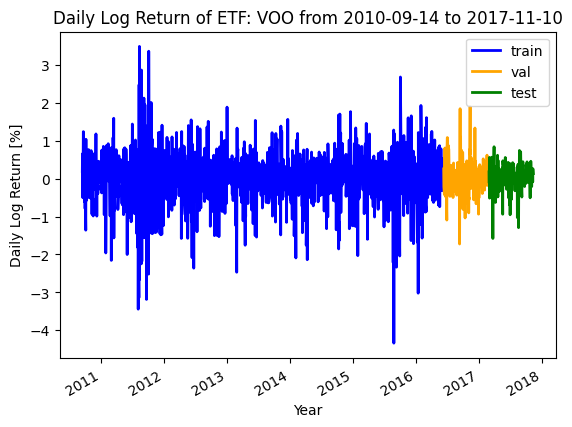

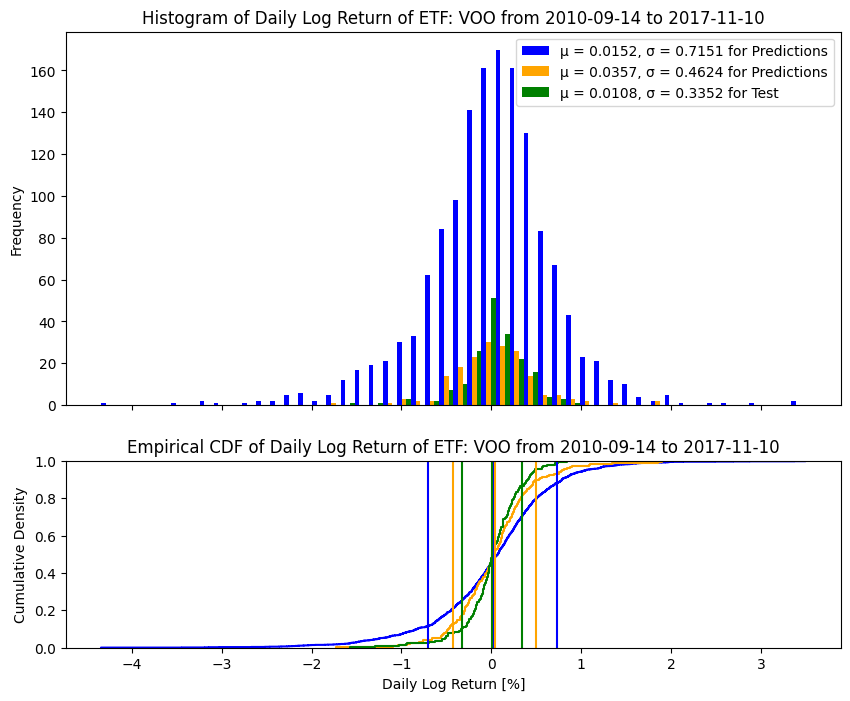

In [10]:
dailyLogReturnTrain = logReturn(train['Open'], train['Close']) * 100
dailyLogReturnVal = logReturn(val['Open'], val['Close']) * 100
dailyLogReturnTest = logReturn(test['Open'], test['Close']) * 100

time_plot(
    train=dailyLogReturnTrain,
    val=dailyLogReturnVal,
    test=dailyLogReturnTest,
    label='Daily Log Return', unit='%', asset_type=asset_type, asset_name=asset_name, colors=colors)

train_mean, train_std = np.mean(dailyLogReturnTrain), np.std(dailyLogReturnTrain)
val_mean  , val_std   = np.mean(dailyLogReturnVal)  , np.std(dailyLogReturnVal)
test_mean , test_std  = np.mean(dailyLogReturnTest) , np.std(dailyLogReturnTest)

print()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

_ = ax1.hist(
    [dailyLogReturnTrain, dailyLogReturnVal, dailyLogReturnTest],
    bins=50,
    color=[colors['train'], colors['val'], colors['test']],
    label=[f"\u03bc = {train_mean:.4f}, \u03c3 = {train_std:.4f} for Predictions",
           f"\u03bc = {val_mean:.4f}, \u03c3 = {val_std:.4f} for Predictions",
           f"\u03bc = {test_mean:.4f}, \u03c3 = {test_std:.4f} for Test"],
    histtype='bar',
    rwidth=1.0,
)

_ = ax1.legend()

_ = ax1.set_title(f'Histogram of Daily Log Return of {asset_type.upper()}: {asset_name.upper()} from {df.index.date[0]} to {df.index.date[-1]}')
_ = ax1.set_ylabel('Frequency')

_ = ax2.ecdf(dailyLogReturnTrain, color=colors['train'])
_ = ax2.ecdf(dailyLogReturnVal, color=colors['val'])
_ = ax2.ecdf(dailyLogReturnTest, color=colors['test'])
_ = ax2.axvline(train_mean, color=colors['train']), ax2.axvline(train_mean + train_std, color=colors['train']), ax2.axvline(train_mean - train_std, color=colors['train'])
_ = ax2.axvline(val_mean  , color=colors['val'])  , ax2.axvline(val_mean + val_std, color=colors['val']), ax2.axvline(val_mean - val_std, color=colors['val'])
_ = ax2.axvline(test_mean, color=colors['test']), ax2.axvline(test_mean + test_std, color=colors['test']), ax2.axvline(test_mean - test_std, color=colors['test'])
_ = ax2.set_title(f'Empirical CDF of Daily Log Return of {asset_type.upper()}: {asset_name.upper()} from {df.index.date[0]} to {df.index.date[-1]}')
_ = ax2.set_ylabel('Cumulative Density')

_ = plt.xlabel('Daily Log Return [%]')

plt.show()

## Preprocessing

In [11]:
preprocessing = Pipeline([
    ('scaler', StandardScaler())
])

In [12]:
def getXY(df, num_days_input=30, num_days_step=1, shuffle=True): # shadow 'df' variable name

  X, y = [], []

  for start_input in range(0, df.shape[0] - num_days_input - 1, num_days_step):
    start_predict = start_input + num_days_input
    preprocessed = preprocessing.fit_transform(df.iloc[start_input:start_predict])
    X.append(preprocessed)
    r = logReturn(df.iloc[start_predict-1]['Close'], df.iloc[start_predict]['Close'])
    y.append(r)

  if shuffle:
    X, y = np.array(X), np.array(y)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]
  else:
    X, y = np.array(X), np.array(y)

  return X, y

In [13]:
train_X, train_y = getXY(train, num_days_input=NUM_DAYS_INPUT, num_days_step=NUM_DAYS_STEP)
val_X,   val_y   = getXY(val,   num_days_input=NUM_DAYS_INPUT, num_days_step=NUM_DAYS_STEP)
test_X,  test_y  = getXY(test,  num_days_input=NUM_DAYS_INPUT, num_days_step=1)

## Modeling

In [14]:
model = keras.Sequential([
    keras.layers.Input(shape=(NUM_DAYS_INPUT, df.shape[1])),
    keras.layers.LSTM(UNITS, return_sequences=True),
    keras.layers.Dropout(DROPOUT_RATE),
    keras.layers.LSTM(UNITS, return_sequences=False),
    keras.layers.Dropout(DROPOUT_RATE),
    keras.layers.Dense(units=1),
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,901 (480.08 KB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
hist = model.fit(
    x=train_X,
    y=train_y,
    validation_data=(np.array(val_X), np.array(val_y)),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0044 - val_loss: 7.4278e-05
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 4.5691e-04 - val_loss: 6.1691e-05
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.3882e-04 - val_loss: 5.4614e-05
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 2.9482e-04 - val_loss: 3.9849e-05
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.2493e-04 - val_loss: 2.8992e-05
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 2.1065e-04 - val_loss: 5.3689e-05
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.7396e-04 - val_loss: 3.4023e-05
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.7297e-04 - val_loss: 3.8217e-05
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.6180e-04 - val_loss: 3.2199e-05
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 1.7509e-04 - val_loss: 7.8897e-05
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.6337e-04 - 

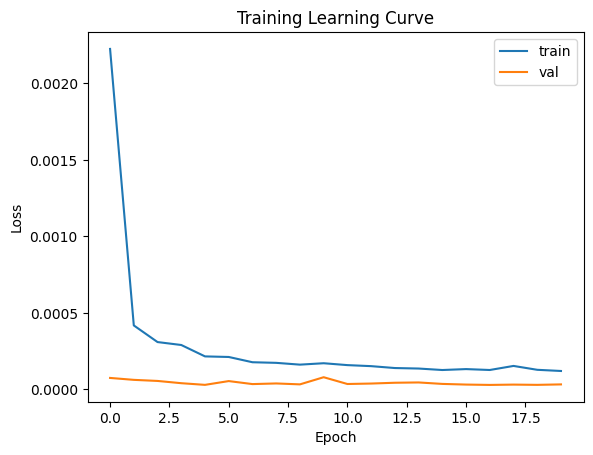

In [16]:
_ = plt.figure()
_ = plt.plot(hist.history['loss'], label='train')
_ = plt.plot(hist.history['val_loss'], label='val')
_ = plt.legend()
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.title('Training Learning Curve')
plt.show()

## Test Prediction and Evaluation

In [17]:
y_pred = model.predict(test_X)[:,0]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


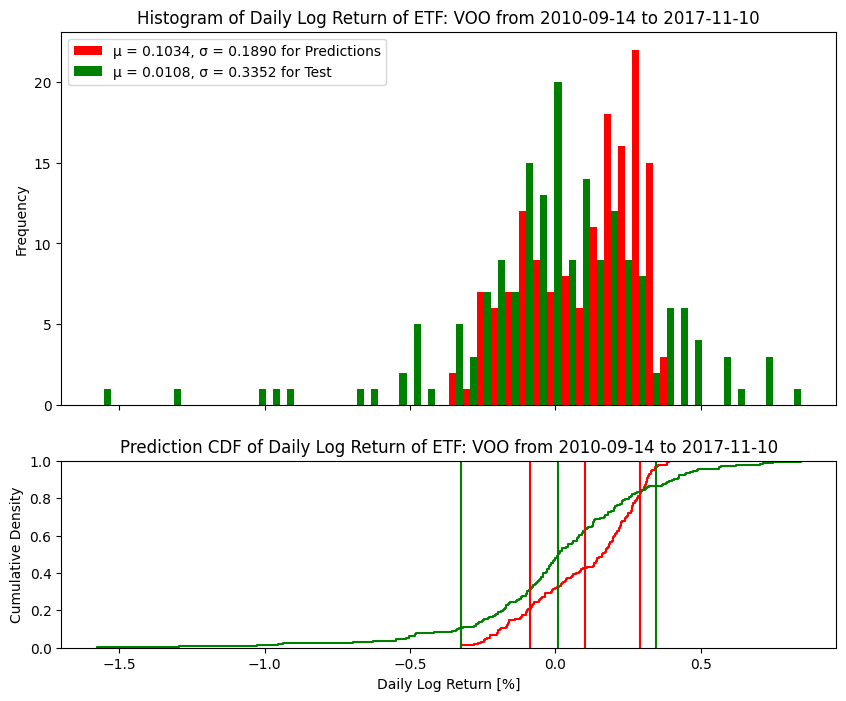

In [18]:
pred_mean = np.mean(100*y_pred)
pred_std = np.std(100*y_pred)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

_ = ax1.hist(
    [100*y_pred, dailyLogReturnTest],
    bins=50,
    color=[colors['pred'], colors['test']],
    label=[f"\u03bc = {pred_mean:.4f}, \u03c3 = {pred_std:.4f} for Predictions",
           f"\u03bc = {test_mean:.4f}, \u03c3 = {test_std:.4f} for Test"],
    histtype='bar',
    rwidth=1.0,
)

_ = ax1.legend()
_ = ax1.set_title(f'Histogram of Daily Log Return of {asset_type.upper()}: {asset_name.upper()} from {df.index.date[0]} to {df.index.date[-1]}')
_ = ax1.set_ylabel('Frequency')

_ = ax2.ecdf(y_pred*100, color=colors['pred'])
_ = ax2.ecdf(dailyLogReturnTest, color=colors['test'])
_ = ax2.axvline(pred_mean, color=colors['pred']), ax2.axvline(pred_mean + pred_std, color=colors['pred']), ax2.axvline(pred_mean - pred_std, color=colors['pred'])
_ = ax2.axvline(test_mean, color=colors['test']), ax2.axvline(test_mean + test_std, color=colors['test']), ax2.axvline(test_mean - test_std, color=colors['test'])
_ = ax2.set_title(f'Prediction CDF of Daily Log Return of {asset_type.upper()}: {asset_name.upper()} from {df.index.date[0]} to {df.index.date[-1]}')
_ = ax2.set_ylabel('Cumulative Density')

_ = plt.xlabel('Daily Log Return [%]')

plt.show()

## Simulation

In [19]:
input = test.iloc[:NUM_DAYS_INPUT]

capital = [INIT_CAPITAL]
capital_naive = [INIT_CAPITAL]
positions = [0]
positions_naive = [0]
predicted_log_returns = [0]
true_log_returns = [0]
multipliers = [0]

prev_sig_mult = 0
window = test.iloc[:NUM_DAYS_INPUT].copy()

for t in range(NUM_DAYS_INPUT, test.shape[0]-1):

  # Scale Input Window and Predict Tomorrow's Log Return

  scaler = preprocessing.fit(window)
  window_scaled = scaler.transform(window)

  pred_log_r = model.predict(np.array([window_scaled]), verbose=0)[0][0]
  predicted_log_returns.append(100 * pred_log_r)


  # Calculate Variance in Realized Logs from Input Window

  realized_logs = logReturn(window['Open'], window['Close'])
  sigma_est = np.std(realized_logs)

  if sigma_est == 0:
    sigma_est = 1e-6


  # Use Fractional Kelly Criterion for Signal Multiplier Calculation

  sig_mult = pred_log_r / (sigma_est**2)
  sig_mult = K_FRAC * np.tanh(sig_mult)
  sig_mult = SMOOTHING_FACTOR*prev_sig_mult + (1-SMOOTHING_FACTOR)*sig_mult
  prev_sig_mult = sig_mult
  multipliers.append(sig_mult)


  # Store True Log Returns

  true_log_r = logReturn(test.iloc[t]['Open'], test.iloc[t]['Close'])
  true_log_returns.append(100 * true_log_r)


  # Position Strategy 1: Fractional Capital Allocation with Predictive Returns

  shares = sig_mult * capital[-1] / test.iloc[t]['Open']
  positions.append(shares)
  daily_profit_loss = positions[-1] * (test.iloc[t]['Close'] - test.iloc[t]['Open'])
  capital.append(capital[-1] + daily_profit_loss)


  # Position Strategy 2: Naive

  shares_naive = capital[-1] / test.iloc[t]['Open']
  positions_naive.append(shares_naive)
  daily_profit_loss_naive = positions_naive[-1] * (test.iloc[t]['Close'] - test.iloc[t]['Open'])
  capital_naive.append(capital_naive[-1] + daily_profit_loss_naive)


  window = test.iloc[t-NUM_DAYS_INPUT+1:t+1].copy()


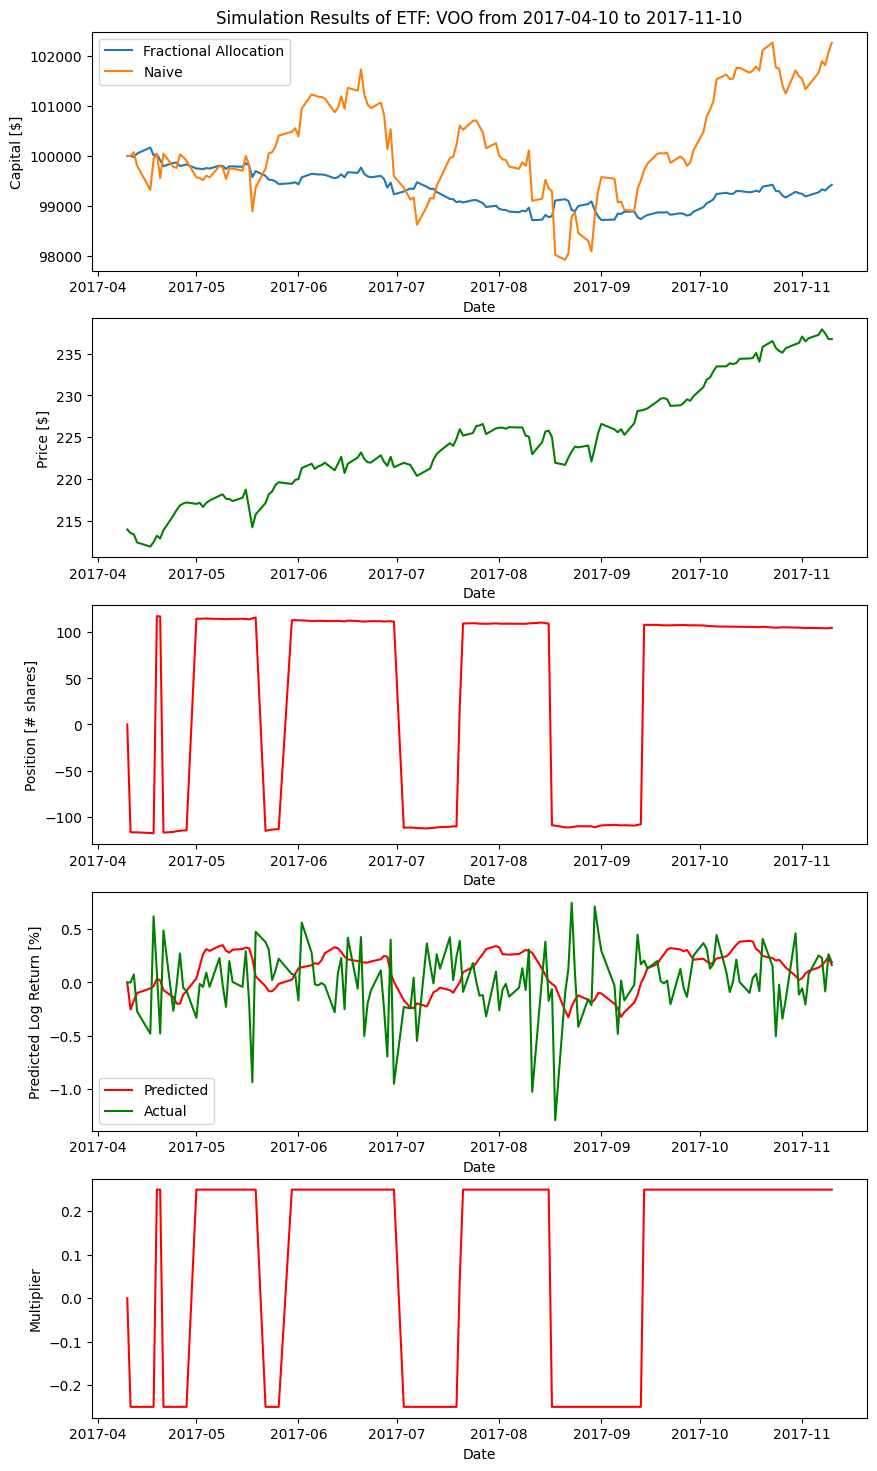

In [21]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 18), sharex=False, gridspec_kw={"height_ratios": [1, 1, 1, 1, 1]})

_ = ax1.set_title(f'Simulation Results of {asset_type.upper()}: {asset_name.upper()} from {test.index.date[NUM_DAYS_INPUT]} to {test.index.date[-1]}')

_ = ax1.plot(test.iloc[NUM_DAYS_INPUT:].index.date, capital)
_ = ax1.plot(test.iloc[NUM_DAYS_INPUT:].index.date, capital_naive)
_ = ax1.legend(['Fractional Allocation', 'Naive'])
_ = ax1.set_xlabel('Date')
_ = ax1.set_ylabel('Capital [$]')

_ = ax2.plot(test.iloc[NUM_DAYS_INPUT:].index.date, test[NUM_DAYS_INPUT:]['Open'], color=colors['test'])
_ = ax2.set_xlabel('Date')
_ = ax2.set_ylabel('Price [$]')

_ = ax3.plot(test.iloc[NUM_DAYS_INPUT:].index.date, positions, color=colors['pred'])
_ = ax3.set_xlabel('Date')
_ = ax3.set_ylabel('Position [# shares]')

_ = ax4.plot(test.iloc[NUM_DAYS_INPUT:].index.date, predicted_log_returns, color=colors['pred'])
_ = ax4.plot(test.iloc[NUM_DAYS_INPUT:].index.date, true_log_returns, color=colors['test'])
_ = ax4.legend(['Predicted', 'Actual'])
_ = ax4.set_xlabel('Date')
_ = ax4.set_ylabel('Predicted Log Return [%]')

_ = ax5.plot(test.iloc[NUM_DAYS_INPUT:].index.date, multipliers, color=colors['pred'])
_ = ax5.set_xlabel('Date')
_ = ax5.set_ylabel('Multiplier')

plt.show()